# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

# Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В ходе анализа предстоит ответить на следующие вопросы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

- work_year	Год, в котором была выплачена зарплата.
- experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- employment_type	Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title	Роль, в которой соискатель работал в течение года.
- salary	Общая выплаченная валовая сумма заработной платы.
- salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- company_size	Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Уровень значимости выбран $\alpha=0.05$.

# Загрузка данных

In [316]:
# импортируем библиотеки
import pandas as pd
import numpy as np

import category_encoders as ce
from scipy import stats
from statsmodels import stats as sms
import association_metrics as am

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("rocket") 

In [317]:
# загружаем датасет
df = pd.read_csv("data/ds_salaries.csv", index_col=0)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [318]:
# задаем уровень значимости
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


# Предобработка


- Проверим нет ли дубликатов и избвимся от них
- Проверим на наличие пропусков 
- Проверим и изменим типы 

In [319]:
print(f"количество дубликатов: {df.duplicated().sum()}")
# избавимся от найденых дубликатов
df.drop_duplicates(inplace=True)
df.info()

количество дубликатов: 42
<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary              565 non-null    int64 
 5   salary_currency     565 non-null    object
 6   salary_in_usd       565 non-null    int64 
 7   employee_residence  565 non-null    object
 8   remote_ratio        565 non-null    int64 
 9   company_location    565 non-null    object
 10  company_size        565 non-null    object
dtypes: int64(4), object(7)
memory usage: 53.0+ KB


Видим, что пропущенных значений нет, salary salary_in_usd имеют правильный тип. Категориальные(в том числе remote_ratio и год) стоит привести к типу category 

## Вычисление неинформативных признаков 
- закодируем категориальные признаки 
- найдем признаки с сильной корреляцией 
- избавимся от ненужных признаков
- проверим несбалансированные признаки   

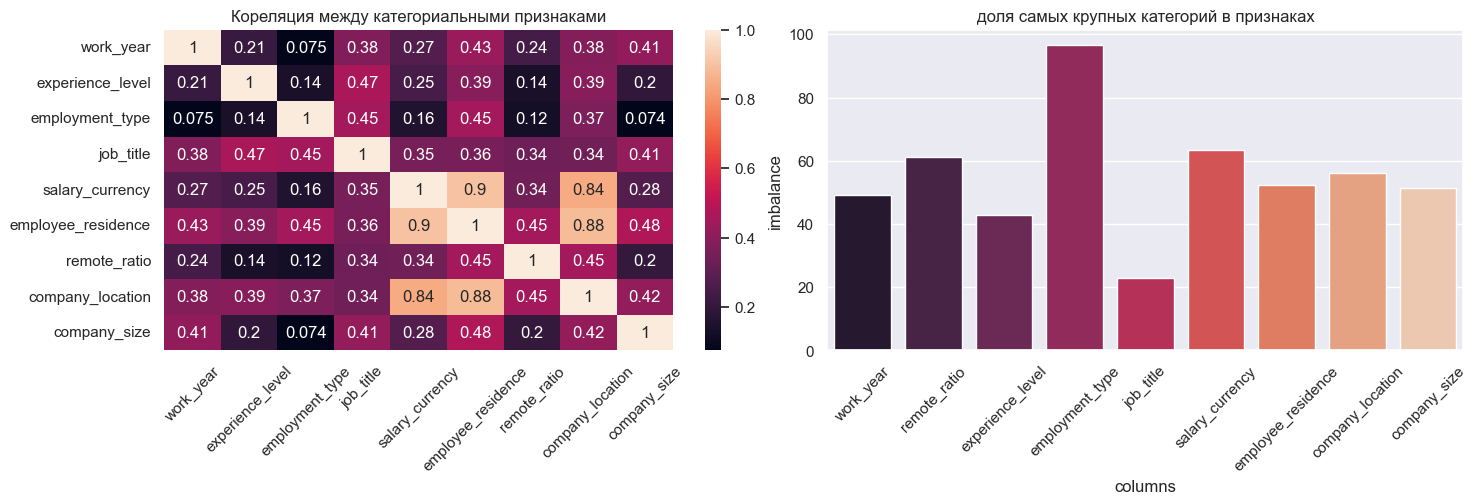

In [320]:
fig, ax = plt.subplots(ncols=2,  figsize=(15, 5))
# изобразим кореляцию cramers v (признаки номинальные(за исключением размера компании и года))
columns = ["work_year", "remote_ratio"]
df["work_year"] = df["work_year"].astype("category")
df["remote_ratio"] = df["remote_ratio"].astype("category")
for col in df.columns:
    if df[col].dtype == "O":
        df[col] = df[col].astype("category")
        columns.append(col)
cramersv = am.CramersV(df)
fig2 = sns.heatmap(cramersv.fit(), annot=True, ax=ax[0], cmap="rocket")
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=45)
ax[0].set_title("Кореляция между категориальными признаками")
plt.tight_layout()
# есть сильно скорелированные признаки между категориальными данными

# изобразим долю самых крупных категорий в признаках ( наверное если на признак приходитяся 90%+ всех данных, то в нем мало пользы)
imbalance = []
for col in columns:
    imbalance.append(list(df[col].value_counts(normalize=True))[0]*100)
bar_data = pd.DataFrame({"imbalance": imbalance, "columns": columns})
fig3 = sns.barplot(bar_data, x="columns", y="imbalance",
                   color="purple", ax=ax[1], palette="rocket")
ax[1].set_title("доля самых крупных категорий в признаках")
fig3.set_xticklabels(fig3.get_xticklabels(), rotation=45)
# удалим неинформативные признаки
df.drop(columns=["employee_residence", "salary_currency",
        "salary", "employment_type"], inplace=True)

## отбор признаков 
Мы точно не будем использовать в анализе следующие признаки:
- employee_residence он не сильно отличается от признака company_location тк работник почти всегда живет в той же стране где и работает 
- salary_currency тк мы не будем сравнивать зарплаты в разных валютах, к тому же валюта зарплаты тоже зависит от местонахождения компании 
- по предыдущей причине не будем использовать признак salary - нет смысла сравнивать зп в разных валютах(нужно привести к одной валюте например к зп в долл.)
- employment_type тк категория FT там встерчается в 96% полей и не несет информативности 

## Основные статистические характеристики для оставшихся полей

In [321]:
df.describe(include="all")

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
count,565.0,565,565,565.000000,565.0,565,565
unique,3.0,4,50,NaN,3.0,50,3
top,2022.0,SE,Data Scientist,NaN,100.0,US,M
freq,278.0,243,130,NaN,346.0,318,290
mean,NaN,NaN,NaN,110610.343363,NaN,NaN,NaN
std,NaN,NaN,NaN,72280.702792,NaN,NaN,NaN
min,NaN,NaN,NaN,2859.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,60757.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,100000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN


# Визуальный анализ 

## Распределение зарплаты

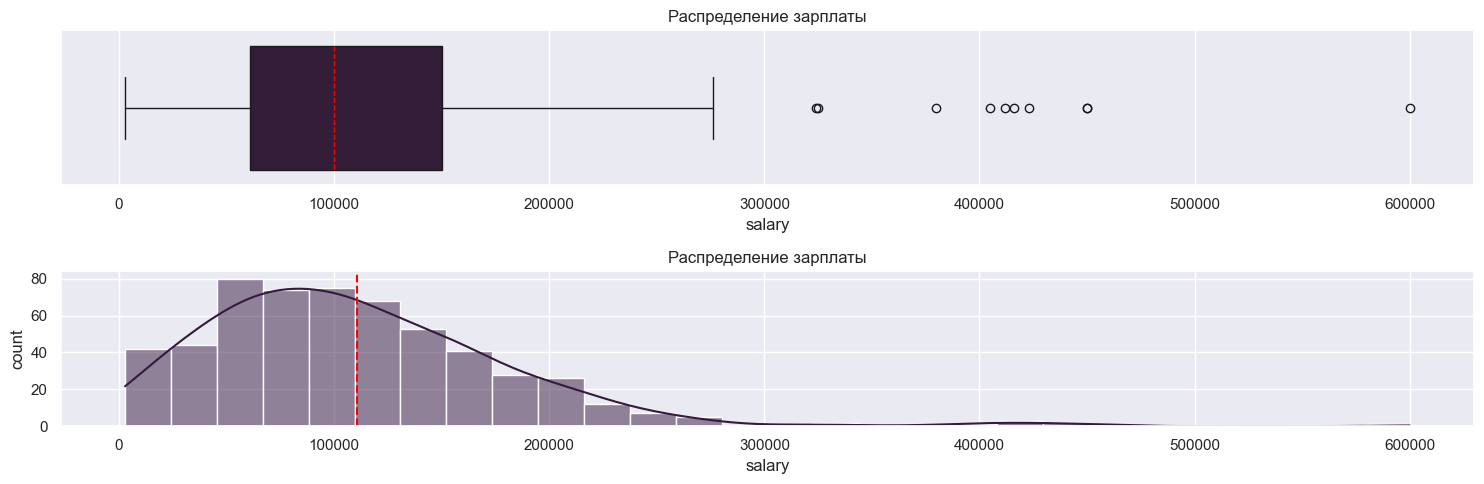

In [322]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 5))
sns.boxplot(df['salary_in_usd'], ax=axes[0], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
axes[0].set(xlabel='salary')
axes[0].set_title('Распределение зарплаты')

sns.histplot(df['salary_in_usd'], kde=True, ax=axes[1])
axes[1].set(xlabel='salary', ylabel='count')
axes[1].set_title('Распределение зарплаты')
axes[1].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--')


plt.tight_layout()
plt.show()

распределение отлично от нормального

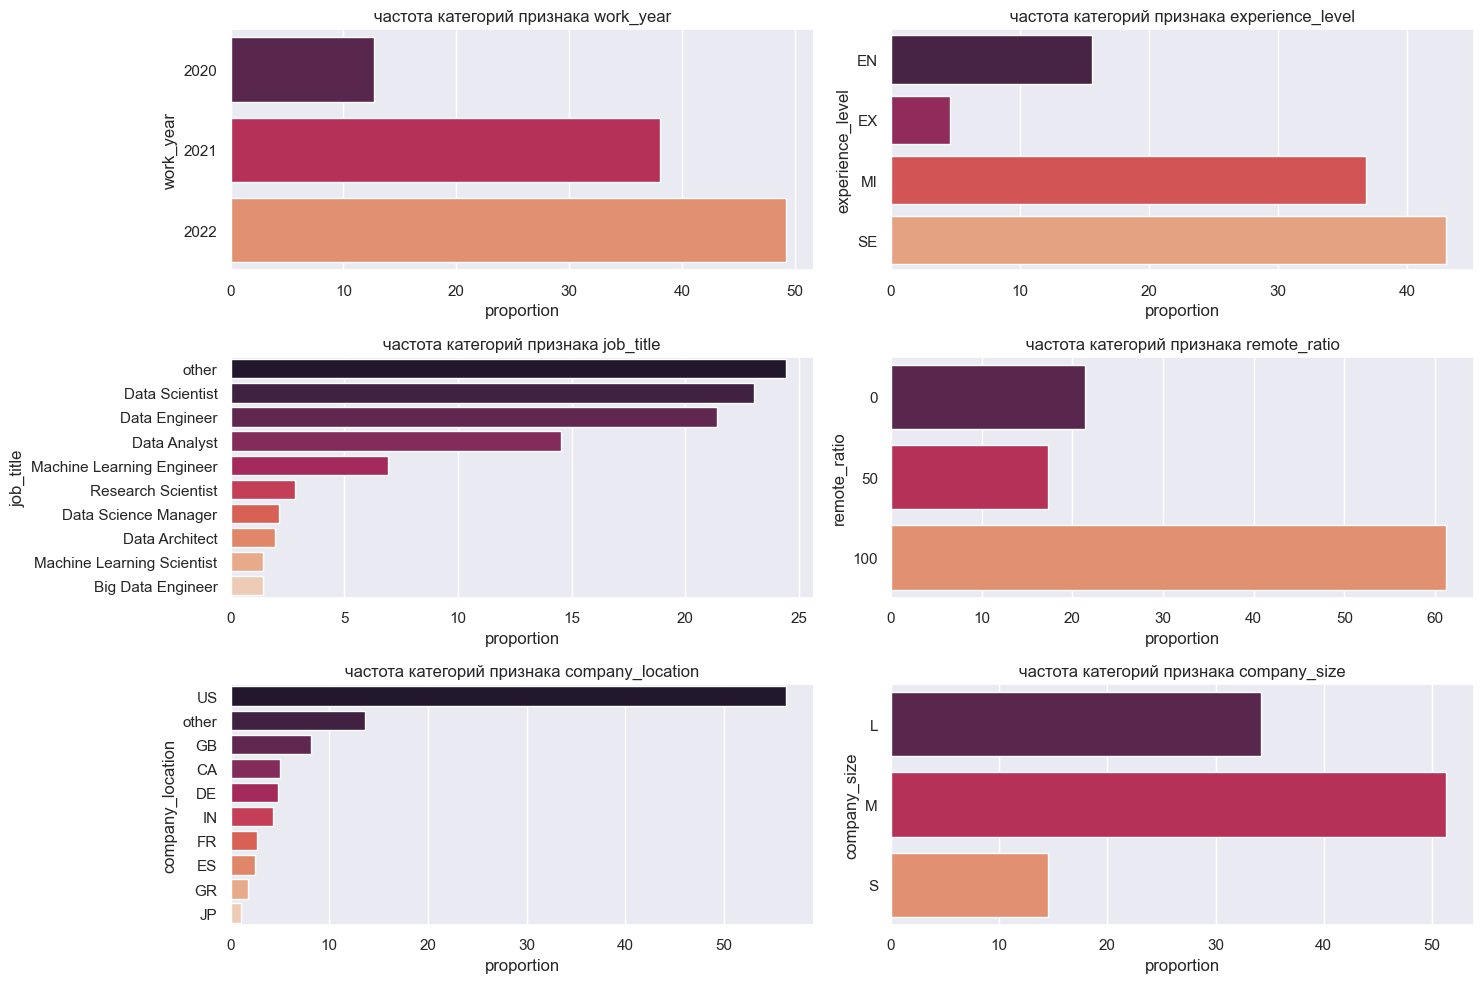

In [345]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=[15, 10])
i = 0
bar_data = df.copy()

for col in bar_data.columns:
    if bar_data[col].dtype != "int64":
        if bar_data[col].nunique() > 10:
            bar_data[col] = bar_data[col].astype(str)
            top10_vals = list(bar_data[col].value_counts().index[:9])
            bar_data[col] = bar_data[col].apply(
                lambda x: x if x in top10_vals else "other")
        sns.barplot(bar_data[col].value_counts(
            normalize=True)*100, ax=ax[int(i/2)][int(i % 2)], orient="h", palette="rocket")
        ax[int(i/2)][int(i % 2)].set_title("частота категорий признака "+col)
        i += 1
plt.tight_layout()
plt.show()

## Зависимость зп от года

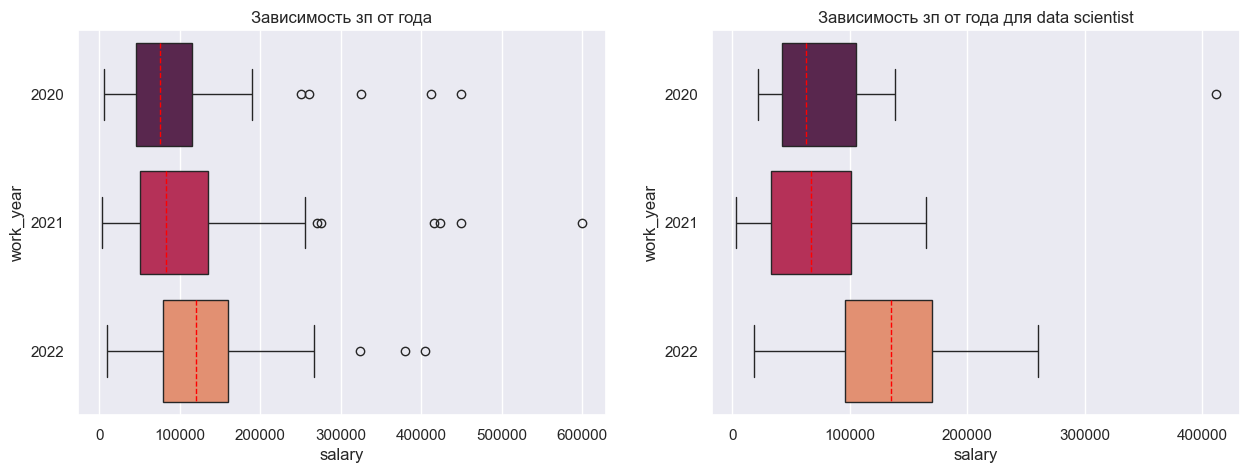

In [324]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(df, x="salary_in_usd", y="work_year", ax=axes[0],  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket")
axes[0].set(xlabel='salary')
axes[0].set_title('Зависимость зп от года')

sns.boxplot(df[df["job_title"] == "Data Scientist"], x="salary_in_usd", y="work_year",
            ax=axes[1],  orient='h', medianprops={"color": "red", "linestyle": '--'}, palette="rocket")
axes[1].set(xlabel='salary')
axes[1].set_title('Зависимость зп от года для data scientist')
fig.show()

В обоих случаях скорее всего нельзя сказать о ежегодном повышении тк медианная зп в 20 и 21 едва ли отличаются 

## Зависимость от experience_level

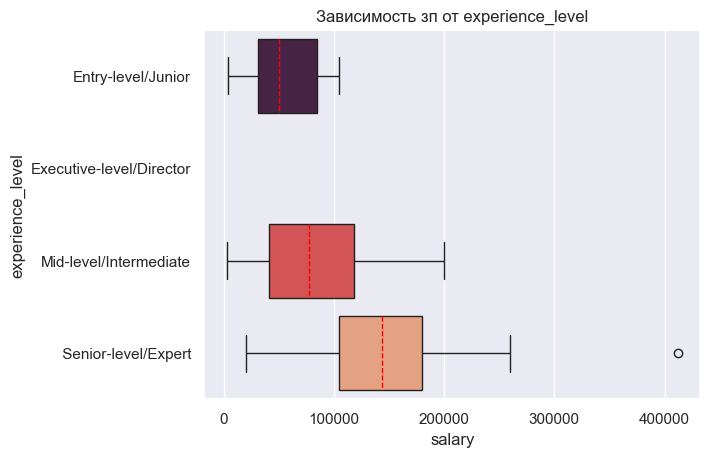

In [347]:
ax = sns.boxplot(df[df["job_title"] == "Data Scientist"], x="salary_in_usd", y="experience_level",
                 orient='h', medianprops={"color": "red", "linestyle": '--'}, palette="rocket")
ax.set(xlabel='salary')
ax.set_yticklabels(["Entry-level/Junior",  "Executive-level/Director",
                   "Mid-level/Intermediate", " Senior-level/Expert"])
ax.set_title('Зависимость зп от experience_level');

Ничего удивительного, уровень опыта сильно влияет на размер зарплаты, кстати нет вакансий для Executive-level

## Зависимомсть зп от объема удаленной работы

Text(0.5, 1.0, 'Зависимомсть зп от объема удаленной работы')

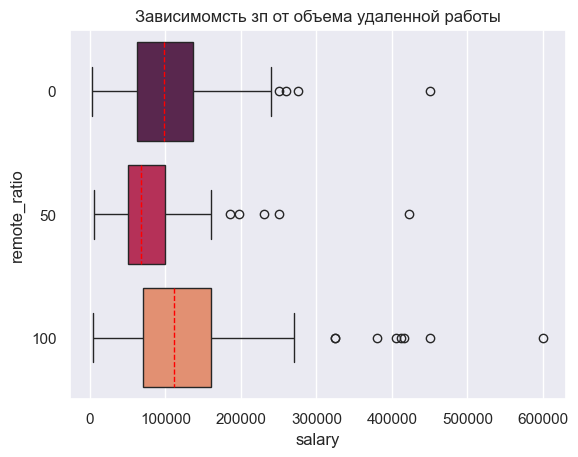

In [326]:
ax = sns.boxplot(df, x="salary_in_usd", y="remote_ratio",  orient='h', medianprops={
                 "color": "red", "linestyle": '--'}, palette="rocket")
ax.set(xlabel='salary')
ax.set_title('Зависимомсть зп от объема удаленной работы')

интересно, что зарплата у позиций с частично удаленной работой ниже чем у остальных. Скорее всего это связано с тем, что новичков редко ставят на полную удаленку. Также может это связано с тем что частичную удаленку предпочитают компании поменьше.(стоит проверить)   

## Соотношение зарплат по разным позициям 

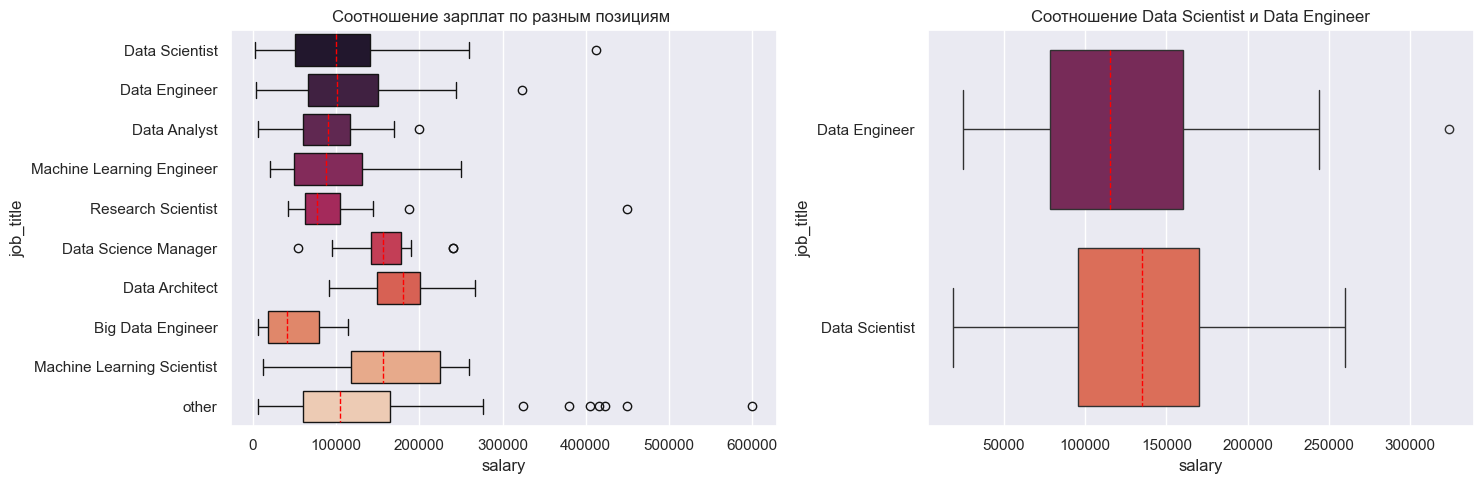

In [327]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
# выделим топ 10 позиций и остальные запишем как другие, отсортируем
top10_jobs = list(df["job_title"].value_counts().index[:9])
box_data = df[["salary_in_usd", "job_title"]]
box_data["job_title"] = box_data["job_title"].astype(str)
box_data["job_title"] = box_data["job_title"].apply(
    lambda x: x if x in top10_jobs else "other")
top10_jobs.append("other")
box_data["place"] = box_data["job_title"].apply(
    lambda x: list(top10_jobs).index(x))
box_data.sort_values(by="place", inplace=True)

sns.boxplot(box_data, x="salary_in_usd", y="job_title", ax=axes[0],  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket")
axes[0].set(xlabel='salary')
axes[0].set_title('Соотношение зарплат по разным позициям ')

# изобразим график для DS и DE
subset = ((df["job_title"] == "Data Scientist") | (
    df["job_title"] == "Data Engineer")) & (df["work_year"] == 2022)
box_data = df[subset]
box_data["job_title"] = box_data["job_title"].astype(str)
sns.boxplot(box_data, x="salary_in_usd", y="job_title", ax=axes[1],  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket")
axes[1].set(xlabel='salary')
axes[1].set_title('Соотношение Data Scientist и Data Engineer')
plt.tight_layout()
fig.show()

Позиция точно влияет на зп(можно проверить разнятся ли медианы)

По вопросам агенства: зп у позиций отличаются примерно на 20к (у data scientist больше)

## Зависимость зп от размеров компаний

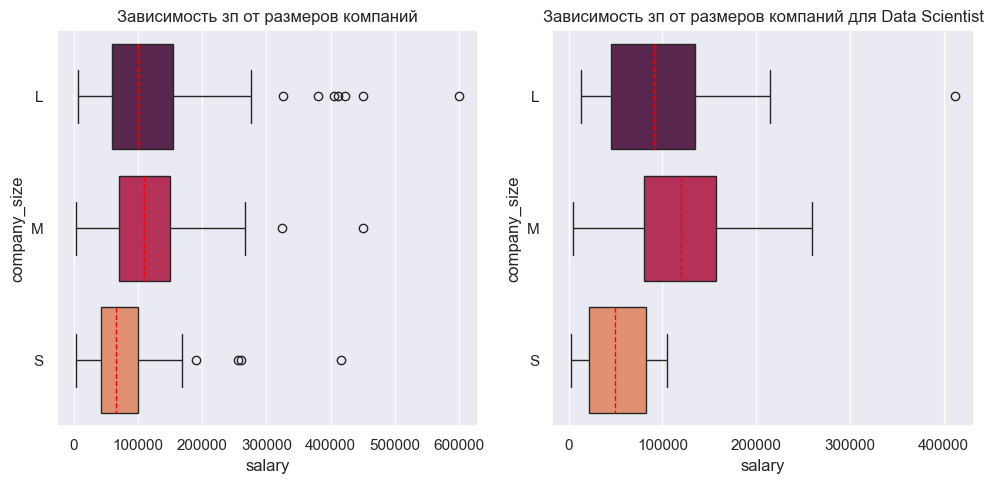

In [328]:
fig, axes = plt.subplots(ncols=2, figsize=[10, 5])
axes[0] = sns.boxplot(df, x="salary_in_usd", y="company_size",  orient='h', medianprops={
    "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[0])
axes[0].set(xlabel='salary')
axes[0].set_title('Зависимость зп от размеров компаний')

subset = (df["job_title"] == "Data Scientist")
box_data = df[subset]
sns.boxplot(box_data, x="salary_in_usd", y="company_size", ax=axes[1],  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket")
axes[1].set(xlabel='salary')
axes[1].set_title('Зависимость зп от размеров компаний для Data Scientist')
plt.tight_layout()
fig.show()

В малых компаниях размер зп существенно ниже чем у других. В больших зп чуть меньше чем в средних, что скорее всего связано с тем, что в крупных компаниях больше сотрудников, в том числе и на низкооплачиваемых позициях.
В тоже время для data scientist это заметнее на графике. Так же может быть такая связь из за того, что малые компании зарабатывают мало, и платят соответсвенно, в то время как в средних компаниях специалисты играют ключевую роль в увеличенни прибыли и платят им соответствующе. В это же время большие компании могут позволить содержать большой штат специалистов, из за чего важность каждого в отдельности и, соответственно, зарплата невелики.

## Cвязь между наличием должностей Data Scientist и Data Engineer и размером компании

In [360]:

pie_data = df.copy()
pie_data["is present"] = (pie_data["job_title"] == "Data Scientist") | (
    pie_data["job_title"] == "Data Engineer")
pie_data = pie_data.groupby(by="company_size", as_index=False)[
    "is present"].value_counts()
pie_data["is present"] = pie_data["is present"].apply(
    lambda x: "present" if x else "non")
pie_data["company_size"] = pie_data["company_size"].replace(
    ["L", "M", "S"], ["Large", "Medium", "Smal"])
fig = px.sunburst(pie_data, names="company_size", color="is present", values="count", path=[
    "company_size", "is present"], width=500, height=450, title="связь между наличием должностей и размером", template="seaborn", color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_traces(textinfo="label+percent parent")
#fig.write_image("plotly/pie.png")
fig.show()

Есть зависимость, в средих компаниях такие специалисты более необходимы, видимо для оптимизации, которая уже есть в крупных но еще не нужна малым компаниям. Или такие специалисты имеют более широкую сферу применения, из за чего малые компании не могут себе позволить, а крупные имеют возможность заменить их узкоспециализированными спецами 

## Cвязь между размером компании, количеством объемом удалённой работы и зп

Проверим связь между использованем удаленки и размером компании.

Text(0.5, 1.0, 'количество мест от размера и удаленки')

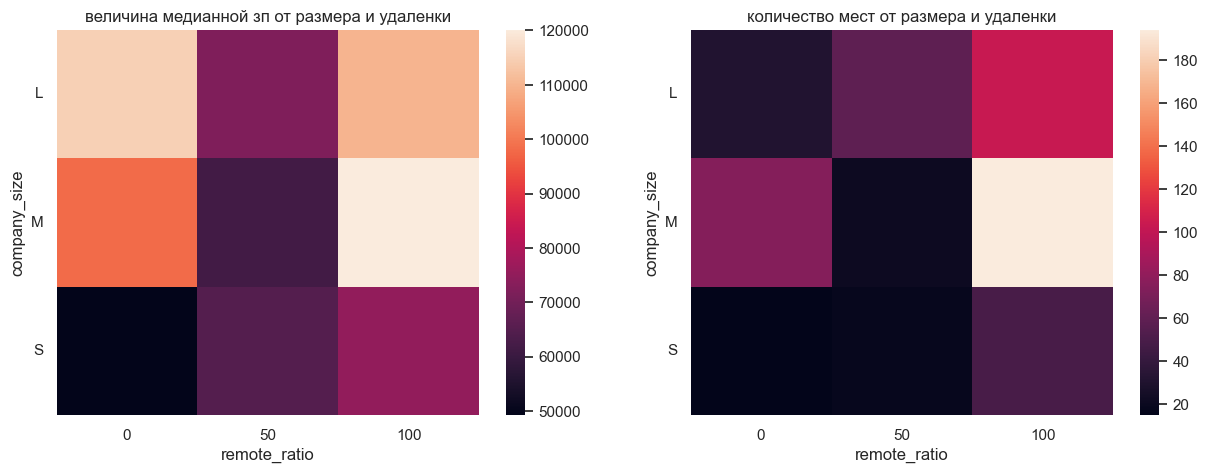

In [330]:
fig, axes = plt.subplots(ncols=2, figsize=[15, 5])
heatmap_data = pd.pivot_table(df, columns="remote_ratio",
                              index="company_size", values="salary_in_usd", aggfunc="median")
sns.heatmap(heatmap_data, ax=axes[0])
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)
axes[0].set_title('величина медианной зп от размера и удаленки')

heatmap_data = pd.pivot_table(df, columns="remote_ratio",
                              index="company_size", values="salary_in_usd", aggfunc="count")
sns.heatmap(heatmap_data, ax=axes[1])
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)
axes[1].set_title('количество мест от размера и удаленки')

посмотрим как меняется доля удаленки для специалистов с разным опытом

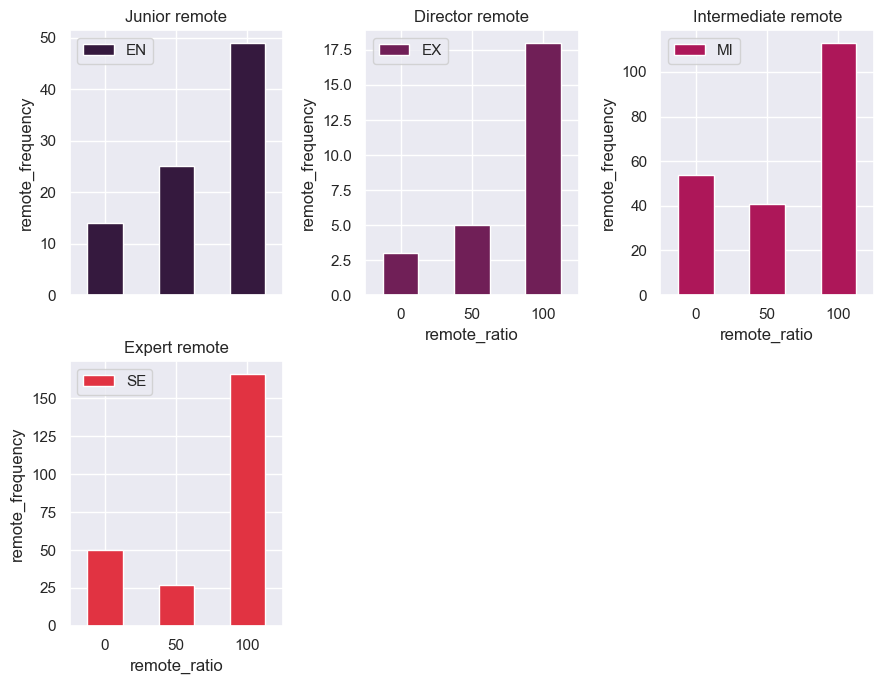

In [331]:
bar_data = df.groupby(by="experience_level")["remote_ratio"].value_counts()
ax = bar_data.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3), title=["Junior remote",  "Director remote",
                                                                                                            "Intermediate remote", "Expert remote"], ylabel="remote_frequency")
plt.tight_layout()

По графикам теперь видно почему наблюдалась странность по отношению к зп при частичной удаленки. Такой вариант работы компании предпочитают в отношении новичков и среднячков(для контроля) и у них зп ниже тк она зависит от опыта работы. Но видимо предположение о предпочтении частичной удаленки малыми компаниями в корне не верно. Также стоит обратить внимание, что крупные компании, как и остальные отдают предпочтение удаленки, но в тоже время медианная зп выше у неудаленной работы. Интересно посмотреть с чем это связано. 

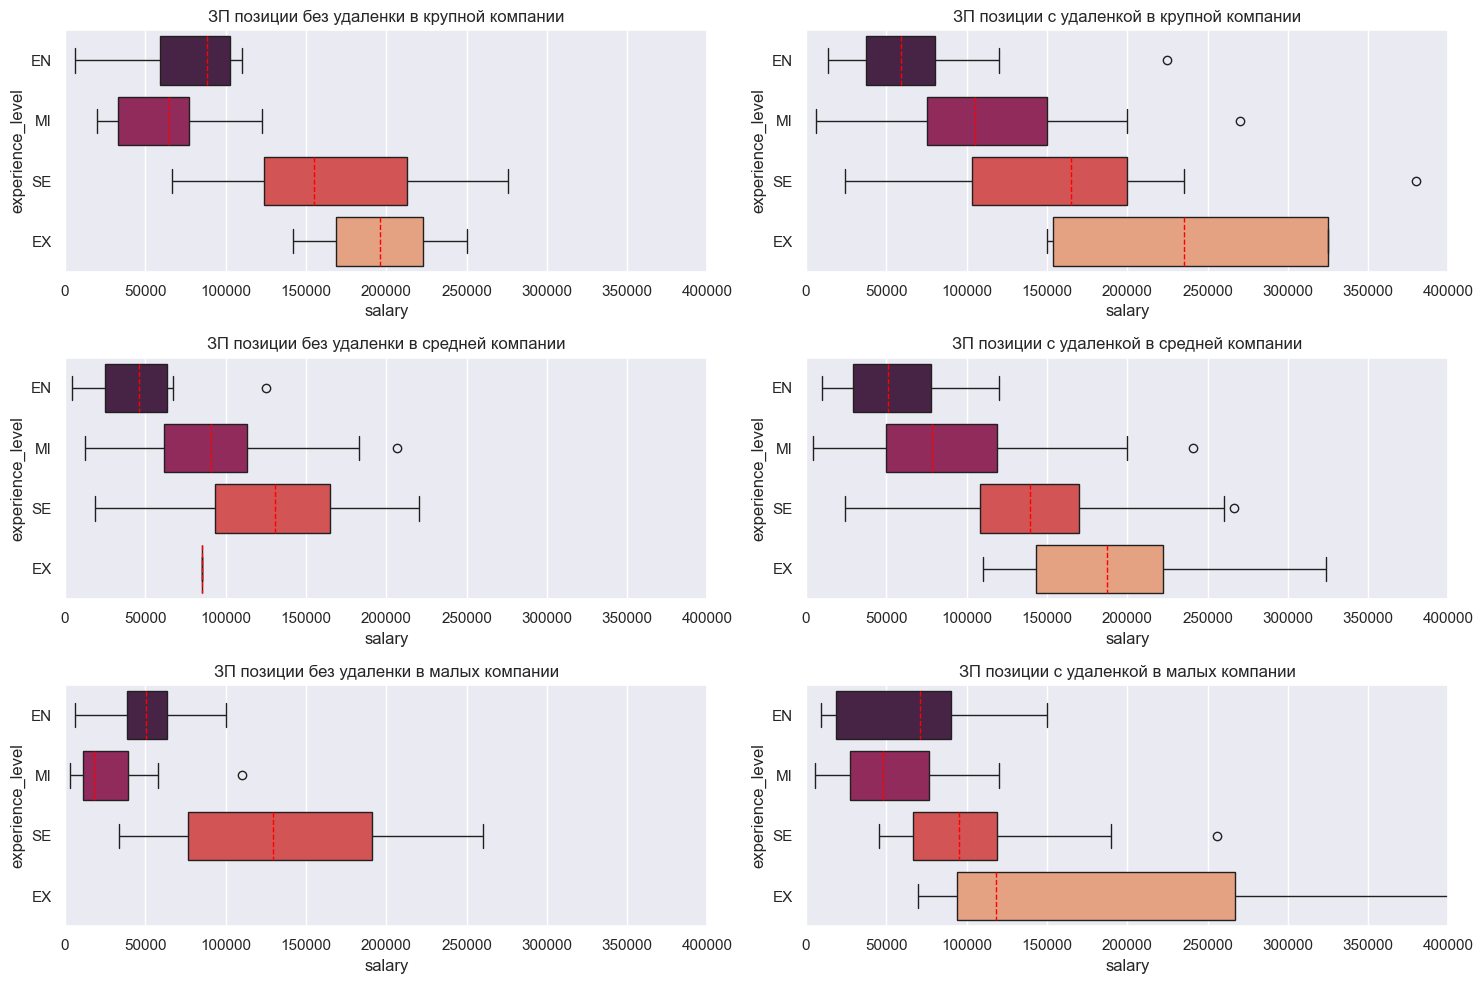

In [332]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=[15, 10])
data = df[(df["company_size"] == "L") & (df["remote_ratio"] == 0)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[0][0], order=["EN", "MI", "SE", "EX"])
axes[0][0].set(xlabel='salary')
axes[0][0].set_title('ЗП позиции без удаленки в крупной компании')
axes[0][0].set_xlim(0, 400_000)

data = df[(df["company_size"] == "L") & (df["remote_ratio"] == 100)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[0][1], order=["EN", "MI", "SE", "EX"])
axes[0][1].set(xlabel='salary')
axes[0][1].set_title('ЗП позиции с удаленкой в крупной компании')
axes[0][1].set_xlim(0, 400_000)

data = df[(df["company_size"] == "M") & (df["remote_ratio"] == 0)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[1][0], order=["EN", "MI", "SE", "EX"])
axes[1][0].set(xlabel='salary')
axes[1][0].set_title('ЗП позиции без удаленки в средней компании')
axes[1][0].set_xlim(0, 400_000)

data = df[(df["company_size"] == "M") & (df["remote_ratio"] == 100)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[1][1], order=["EN", "MI", "SE", "EX"])
axes[1][1].set(xlabel='salary')
axes[1][1].set_title('ЗП позиции с удаленкой в средней компании')
axes[1][1].set_xlim(0, 400_000)
plt.tight_layout()

data = df[(df["company_size"] == "S") & (df["remote_ratio"] == 0)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[2][0], order=["EN", "MI", "SE", "EX"])
axes[2][0].set(xlabel='salary')
axes[2][0].set_title('ЗП позиции без удаленки в малых компании')
axes[2][0].set_xlim(0, 400_000)

data = df[(df["company_size"] == "S") & (df["remote_ratio"] == 100)]
sns.boxplot(data, x="salary_in_usd", y="experience_level",  orient='h', medianprops={
            "color": "red", "linestyle": '--'}, palette="rocket", ax=axes[2][1], order=["EN", "MI", "SE", "EX"])
axes[2][1].set(xlabel='salary')
axes[2][1].set_title('ЗП позиции с удаленкой в малых компании')
axes[2][1].set_xlim(0, 400_000)
plt.tight_layout()

Важное, что хотелось бы отметить, что в крупных компаниях у джунов на неудаленной работе зп выше чем у и колег на удаленке. Скорее всего именно это влияет на "аномалию" в предыдущем выводе.
В средних и малых компаниях нет, или почти нет менеджеров (EX) на неудаленной позиции


Выводы по доп иследованию:
- компании предпочитают удаленку, позиций больше, зп больше 
- в крупных компаниях предпочтение удаленки сохраняется, но медианная зп ниже чем на неудаленной работе, что связано с зп джунов 
- в зависимости от увеличения размера компании чаще используется частичная удаленка 
- частичная удаленка преимущественно используется в крупных компаниях для контроля (обучения) мидов и джунов 
- в связи с предыдущим пунктом в крупных компаниях есть менеджеры работающие неудаленно, а в остальных нет(или почти нет)
- в крупных компаниях джуны на удаленке получают меньше чем те, кто сидит в офисе 

# Статистические тесты 

Переходим к проверке выдвинутых гипотез. Начнем с интересующих агенство выводов:
- скорее всего нельзя сказать о ежегодном повышении зп тк медианная зп в 20 и 21 едва ли отличаются
- зп у Data Scientist и Data Engineer отличаются примерно на 20к (у data scientist больше)
- В малых компаниях размер зп существенно ниже чем у других. В больших зп чуть меньше чем в средних
- есть связи между размером компании и наличием должностей 
для начала подтвердим вывод о ненормальности распеределения зп, сделанного в начале иследования  

Реализуем автоматический выбор теста в зависимости от входных параметров как на картинке

<center> <img src = https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@DST_EDA_4_8_1.png alt="drawing" style="width:800px;">


In [350]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


def automatic_test(*args, rel: bool = False, alternative: str = "two-sided", popmean: float = 0):
    """функция автоматически проводит проверку на нормальность на основе заданого 
    уровня значимости и в зависимости от длины исходного масива и значения rel проводит соответствующий тест


    Args:
        args (pd.series or list of pd.series): данные для теста
        rel (bool, optional): зависимы ли данные или нет. Defaults to False.
        alternative (str, optional) альтернативная гипотеза {‘two-sided’, ‘less’, ‘greater’}
        popmean (float, optional) мат ожидание для одновыборочного критерия 
    """

    # проверяем является ли каждая в отдельности выборка нормально распределенной, True будет записано в переменную если все выборки одновременно нормально распределенны
    is_gaus = []
    for i in range(len(args)):
        is_gaus.append(stats.shapiro(args[i])[1] > alpha)
    is_gaus = sum(is_gaus) == len(args)

    if len(args) == 1:
        # одновыборочные тесты
        if is_gaus > alpha:
            print("Данные распределенны нормально, проводим одновыборочный t-тест")
            _, p_value = stats.ttest_1samp(
                *args, popmean=popmean, alternative=alternative)
        else:
            print("Данные распределенны ненормально, используем критерий знаков")
            _, p_value = sms.descriptivestats.sign_test(args, popmean)
    elif len(args) == 2:
        # двухвыборочные тесты
        if is_gaus > alpha:
            if rel:
                print("Данные распределенны нормально, проводим парный t-тест")
                _, p_value = stats.ttest_rel(
                    args[0], args[1], alternative=alternative)
            else:
                print("Данные распределенны нормально, проводим двухвыборочный t-тест")
                # проверка на равенство дисперсий
                eq_var = stats.levene(*args)[1] > alpha
                _, p_value = stats.ttest_ind(
                    args[0], args[1], alternative=alternative, equal_var=eq_var)
        else:
            if rel:
                print("Данные распределенны ненормально, проводим тест Уилкинсона")
                _, p_value = stats.wilcoxon(
                    args[0], args[1], alternative=alternative)
            else:
                print("Данные распределенны ненормально, проводим тест Манна-Уитни")
                _, p_value = stats.mannwhitneyu(
                    args[0], args[1], alternative=alternative)
    elif len(args) >= 3:
        # тесты для нескольких выборок
        # проверка на равенство дисперсий
        eq_var = stats.levene(*args)[1] > alpha
        if is_gaus > alpha and eq_var and not rel:
            print("Данные распределенны нормально, проводим Anova")
            _, p_value = stats.f_oneway(*args)
        else:
            if rel:
                print("Данные распределенны ненормально, проводим тест Фридмана")
                _, p_value = stats.friedmanchisquare(*args)
            else:
                print(
                    "Данные распределенны ненормально, проводим тест Краскела-Уоллиса ")
                _, p_value = stats.kruskal(*args)
    print('p-value = {:.3f}'.format(p_value))
    if p_value <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак ЗП нормально.

In [351]:
print("распределение Зарплаты в датасете:")
decision_normality(stats.shapiro(df["salary_in_usd"])[1])

распределение Зарплаты в датасете:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


### проверим, что в среднем зп составляет 100к  

In [352]:
automatic_test(df["salary_in_usd"], popmean=100000)

Данные распределенны ненормально, используем критерий знаков
p-value = 0.966
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**вывод**

Действительно средняя зп состаляет 100к 

### Нет ежегодного повышения зп тк медианная зп в 20 и 21 едва ли отличаются


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Нет разницы в зп для 2020 и 2021: зп в 2021 ($μ_1$), зп в 2020 ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза*: зп в 2021 больше чем в 2020.

$$ H_1 : μ_1 < μ_2 $$

Аналогичны нулевые и альтернативные гипотезы для зп в 2022 ($μ_1$), зп в 2021 ($μ_2$)


In [353]:
print("проводим тест для данных 2020 и 2021")
charges_ds_2020 = df[(df["work_year"] == 2020) & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
charges_ds_2021 = df[(df["work_year"] == 2021) & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
automatic_test(charges_ds_2021, charges_ds_2020, alternative="greater")

print("____________________________________")
print("проводим тест для данных 2021 и 2022")
charges_ds_2021 = df[(df["work_year"] == 2021) & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
charges_ds_2022 = df[(df["work_year"] == 2022) & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
automatic_test(charges_ds_2022, charges_ds_2021, alternative="greater")

проводим тест для данных 2020 и 2021
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
____________________________________
проводим тест для данных 2021 и 2022
Данные распределенны нормально, проводим двухвыборочный t-тест
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Выводы**
 
у нас недостаточно данных, чтобы говорить о ежегодном повышении ЗП для специалистов data science, единственное что мы можем сказать, что медианая зп в 2022 году больше, чем в 2021 ( мб связано с увеличением количества средних и крупных компаний)

### ЗП у Data Scientist и Data Engineer а 2022 отличаются примерно на 20к (у data scientist больше)


*Нулевая гипотеза*: Нет разницы в зп у Data Scientist и Data Engineer: зп у Data Scientist ($μ_1$), зп у Data Engineer ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза*: зп у data scientist больше.

$$ H_1 : μ_1 < μ_2 $$


In [349]:
print("проводим тест для зп Data Scientist и Data Engineer в 2022 году")
charges_ds = df[(df["work_year"] == 2022) & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
charges_de = df[(df["work_year"] == 2022) & (
    df["job_title"] == "Data Engineer")]["salary_in_usd"]
automatic_test(charges_ds, charges_de, alternative="greater")

проводим тест для зп Data Scientist и Data Engineer в 2022 году
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Выводы**
 
Казалось бы разница в 20к внушительная, но она не обладает статистической значимостью для выбраного нами уровня значимости, у специалистов ЗП не отличаются 

### В малых компаниях размер зп существенно ниже чем у других. В больших зп чуть меньше чем в средних


*Нулевая гипотеза*: Нет разницы в зп у компаний разных размеров: зп у Data Scientist в малых компаниях ($μ_1$), зп у Data Scientist в крупных компаниях ($μ_2$) и средних ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: есть разница.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

В случае принятия альтернотивной гипотезы проведем доп тесты для установления 
1. в малых компаниях меньше зп(нулевая: разницы нет; альтернативная: в  малых *меньше* зп)
1. в крупных компаниях меньше зп чем в средних(нулевая: разницы нет; альтернативная: в  крупных *меньше* чем в средних)

In [338]:
charges_ds_s = df[(df["company_size"] == "S") & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
charges_ds_m = df[(df["company_size"] == "M") & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
charges_ds_l = df[(df["company_size"] == "L") & (
    df["job_title"] == "Data Scientist")]["salary_in_usd"]
automatic_test(charges_ds_s, charges_ds_m, charges_ds_l)
print("зп в компаниях отличаются, проведем парные тесты")
print("______________________________________________")
print("проверяем разницу для малых и больших компаний")
automatic_test(charges_ds_s, charges_ds_l, alternative="less")
print("______________________________________________")
print("проверяем разницу для средних и больших компаний")
automatic_test(charges_ds_l, charges_ds_m, alternative="less")

Данные распределенны ненормально, проводим тест Краскела-Уоллиса 
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
зп в компаниях отличаются, проведем парные тесты
______________________________________________
проверяем разницу для малых и больших компаний
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
______________________________________________
проверяем разницу для средних и больших компаний
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.024
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Выводы**

Итого, зп зависит от величины компании, причем в средних платят больше всего, в малых - меньше всего 
Так же стоит отметить еще возможную причину такой разницы: в крупных компаниях экономят на зп, но могут компенсировать "плюшками" типа соц пакетов, оплаты проезда и жилья

### есть связи между размером компании и наличием должностей 

*Нулевая гипотеза*: никакой связи между размером компании и наличием должностей нет .

*Альтернативная гипотеза*: есть зависимость.

In [339]:
cross_data = df.copy()
cross_data["is present"] = (cross_data["job_title"] == "Data Scientist") | (
    cross_data["job_title"] == "Data Engineer")
cross_table = pd.crosstab(cross_data["is present"], cross_data['company_size'])
decision_hypothesis(stats.chi2_contingency(cross_table)[1])

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Выводы**

Есть связь между наличием должности и размером компании

### Выводы для агенства


- у нас недостаточно данных, чтобы говорить о ежегодном повышении ЗП для специалистов data science
- у специалистов DS и DE зарплаты не отличаются 
- зп зависит от величины компании, причем в средних платят больше всего, в малых - меньше всего 
- Есть связь между наличием должности и размером компании

### Доп статистические тесты

### Зависимость зарплаты от опыта для Data Scientist

Для начала проверим значимость очевидного факта, что зп зависит от опыта.

Попарно проверим две гипотезы, что джун получает меньше мида, а мид меньше синьора
1.  *Нулевая гипотеза*: зарплаты джунов ($μ_1$) и мидов ($μ_2$) не отличаются  $μ_1$ = $μ_2$

    *Альтернативная гипотеза*: $μ_1$ < $μ_2$.
    
2.  *Нулевая гипотеза*:  зарплаты мидов ($μ_1$) и синьоров ($μ_2$) не отличаются  $μ_1 = μ_2$.

    *Альтернативная гипотеза*: $μ_1 < μ_2$.

In [340]:
charges_jn = df[(df['experience_level'] == "EN") & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
charges_mi = df[(df['experience_level'] == "MI") & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
charges_se = df[(df['experience_level'] == "SE") & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
print("проверка первой гипотезы")
automatic_test(charges_jn, charges_mi, alternative="less")
print("________________________")
print("проверка второй гипотезы")
automatic_test(charges_mi, charges_se, alternative="less")

проверка первой гипотезы
Данные распределенны нормально, проводим двухвыборочный t-тест
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
________________________
проверка второй гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Выводы**

Что и требовалось ожидать, опыт непосредственно влияет на зп

### Зависимость от объема удаленной работы для Data Scientist

Попарно проверим две гипотезы, что зп для частичной удаленки меньше полной. В то время как зп полной удаленки и отсутствия удаленки не отличаются
1.  *Нулевая гипотеза*: зарплаты у позиций с частичной удаленкой ($μ_1$) и позиций с полной ($μ_2$) не отличаются  $μ_1$ = $μ_2$

    *Альтернативная гипотеза*: ($μ_1$) < ($μ_2$).
    
2.  *Нулевая гипотеза*:  зарплаты у позиций с полной удаленкой ($μ_1$) и отсутствием ($μ_2$) не отличаются  $μ_1$ = $μ_2$.

    *Альтернативная гипотеза*: $ μ_1 \neq μ_2 $.

In [341]:
charges_0 = df[(df['remote_ratio'] == 0) & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
charges_50 = df[(df['remote_ratio'] == 50) & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
charges_100 = df[(df['remote_ratio'] == 100) & (
    df['job_title'] == "Data Scientist")]["salary_in_usd"]
print("проверка первой гипотезы")
automatic_test(charges_50, charges_100, alternative="less")
print("________________________")
print("проверка второй гипотезы")
automatic_test(charges_0, charges_100)

проверка первой гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
________________________
проверка второй гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.233
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Выводы**

специалистам на частичной удаленке действительно платят меньше. Разницы в зарплатах между полной удаленкой и отсутствием таковой нет

### Отличаются зп удаленной и неудаленной работ в крупных организациях 

Проверим гипотезу,
*Нулевая гипотеза*: зарплаты в крупных компаниях у позиций с полной удаленкой ($μ_1$) и позиций с полной ($μ_2$) не отличаются  $μ_1 = μ_2$

*Альтернативная гипотеза*: $μ_1 > μ_2$.

аналогичный тест проведем для средних и малых компаний

In [354]:
charges_L_0 = df[(df['remote_ratio'] == 0) & (df['job_title'] ==
                                              "Data Scientist") & (df['company_size'] == "L")]["salary_in_usd"]
charges_L_100 = df[(df['remote_ratio'] == 100) & (
    df['job_title'] == "Data Scientist") & (df['company_size'] == "L")]["salary_in_usd"]
print("проверка первой гипотезы")
automatic_test(charges_L_0, charges_L_100, alternative="greater")
print("________________________")
print("проверка второй гипотезы")
charges_M_0 = df[(df['remote_ratio'] == 0) & (df['job_title'] ==
                                              "Data Scientist") & (df['company_size'] == "M")]["salary_in_usd"]
charges_M_100 = df[(df['remote_ratio'] == 100) & (
    df['job_title'] == "Data Scientist") & (df['company_size'] == "M")]["salary_in_usd"]
automatic_test(charges_M_0, charges_M_100, alternative="less")
print("________________________")
print("проверка третьей гипотезы")
charges_S_0 = df[(df['remote_ratio'] == 0) & (df['job_title'] ==
                                              "Data Scientist") & (df['company_size'] == "S")]["salary_in_usd"]
charges_S_100 = df[(df['remote_ratio'] == 100) & (
    df['job_title'] == "Data Scientist") & (df['company_size'] == "S")]["salary_in_usd"]
automatic_test(charges_S_0, charges_S_100, alternative="less")

проверка первой гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.060
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
________________________
проверка второй гипотезы
Данные распределенны нормально, проводим двухвыборочный t-тест
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
________________________
проверка третьей гипотезы
Данные распределенны нормально, проводим двухвыборочный t-тест
p-value = 0.239
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**выводы**

На самом деле здесь пригодилось бы какое нибудь доп иследование тк p_value в 0,06 кажется все еще неплохим результатом. Те существует неплохая вероятность, что указанная разница (за удаленку платят меньше в крупных компаниях) действительно есть.
В тоже время в средних компаниях за удаленку платят больше, а в малых компаниях нет разницы 

### зависимость зп в крупных компаниях от опыта работы 

проверим в крупных компаниях зарплаты на удаленки и офисных работников:
1. у джунов в офисе зп выше
2. у мидов на удаленке зп выше 
3. у сеньоров на удаленке зп выше 
4. у джунов в офисе зп выше чем у мидов в офисе 

In [343]:
print("проверка первой гипотезы")
charges_0_en = df[(df['remote_ratio'] == 0) & (
    df['experience_level'] == "EN") & (df['company_size'] == "L")]["salary_in_usd"]
charges_100_en = df[(df['remote_ratio'] == 100) & (
    df['experience_level'] == "EN") & (df['company_size'] == "L")]["salary_in_usd"]
automatic_test(charges_0_en, charges_100_en, alternative="greater")
print("________________________")
print("проверка второй гипотезы")
charges_0_mi = df[(df['remote_ratio'] == 0) & (
    df['experience_level'] == "MI") & (df['company_size'] == "L")]["salary_in_usd"]
charges_100_mi = df[(df['remote_ratio'] == 100) & (
    df['experience_level'] == "MI") & (df['company_size'] == "L")]["salary_in_usd"]
automatic_test(charges_100_mi, charges_0_mi, alternative="greater")
print("________________________")
print("проверка третьей гипотезы")
charges_0_se = df[(df['remote_ratio'] == 0) & (
    df['experience_level'] == "SE") & (df['company_size'] == "L")]["salary_in_usd"]
charges_100_se = df[(df['remote_ratio'] == 100) & (
    df['experience_level'] == "SE") & (df['company_size'] == "L")]["salary_in_usd"]
automatic_test(charges_100_se, charges_0_se, alternative="greater")
print("________________________")
print("проверка четвертой гипотезы")
automatic_test(charges_0_en, charges_0_mi, alternative="greater")

проверка первой гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.265
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
________________________
проверка второй гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
________________________
проверка третьей гипотезы
Данные распределенны ненормально, проводим тест Манна-Уитни
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
________________________
проверка четвертой гипотезы
Данные распределенны нормально, проводим двухвыборочный t-тест
p-value = 0.338
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


ЗП джунов и сеньоров не отличаются в зависимости от работы в офисе и на удаленке. ЗП мидов на удаленке выше. Аномалия в разнице между зп джунов и мидов в офисе в крупных компаниях не являтся статистически значимой.

все гипотезы были опровергнуты. Судя по всему на итогувую зп влияет именно соотношение работников (в офисе работает меньше джунов с низкой зп)

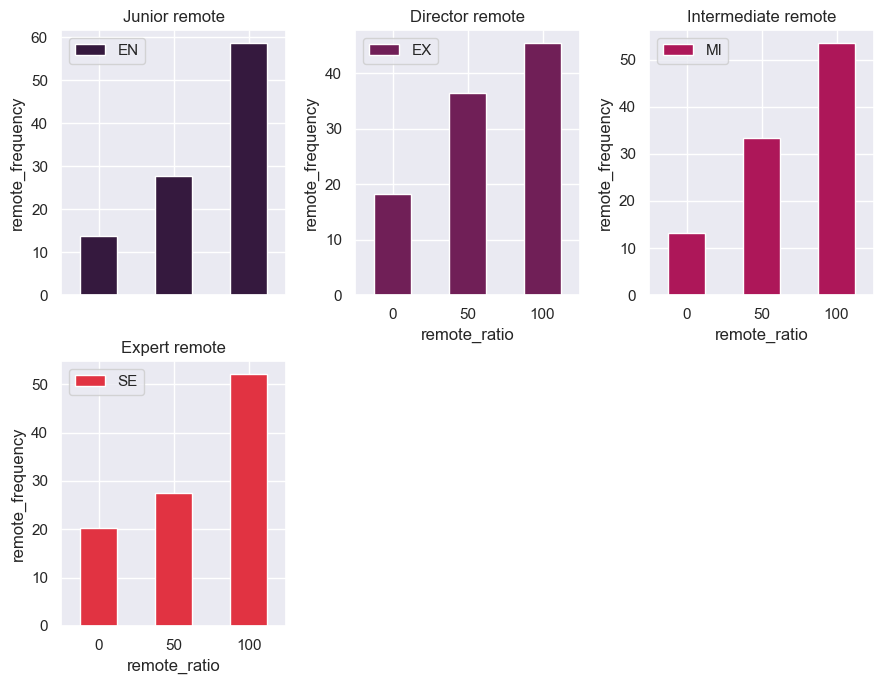

In [344]:
bar_data = df[df["company_size"] == "L"].groupby(by="experience_level")[
    "remote_ratio"].value_counts(normalize=True)*100
ax = bar_data.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3), title=["Junior remote",  "Director remote",
                                                                                                            "Intermediate remote", "Expert remote"], ylabel="remote_frequency")
plt.tight_layout()

Видимо вклад джунов в итогувую оценку зп на неудаленной позиции ниже (процент джунов и мидов в офисе ниже чем других специалистов)


Общие выводы по работе:
- у нас недостаточно данных, чтобы говорить о ежегодном повышении ЗП для специалистов data science
- у специалистов DS и DE в 2022 зарплаты не отличаются 
- зп зависит от величины компании, причем в средних платят больше всего, в малых - меньше всего 
- Есть связь между наличием должности и размером компании
- ЗП специалистов DS прямо пропорциональна опыту работы
- специалистам на частичной удаленке зачастую платят меньше чем остальным
- с увеличением размера компании, растет процент работников на частичной удаленке (конкретно мидов и менеджеров(директоров)) 
- соотношение зп за удаленку и работу в офисе напрямую зависит от величины компании, причем:
    - В крупных за работу в офисе платят больше (меньше джунов относительно низкими зп)
    - В средних за удаленку платят больше 
    - В малых разницы нет 
- Для всех размеров компаний удаленка предпочтительнее 
